In [1]:
# TensorFlow and tf.keras

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow.keras.utils
import pandas as pd

# import keras
# import keras.backend
# from keras import layers
# from keras import models
# import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

2.0.0


In [11]:
data = np.load('/mnt/data/ml/Constituent4vecData_2cat.npz')
evnum = data['jetconstEvnum']
pt = data['jetconstPt']
eta = data['jetconstEta']
phi = data['jetconstPhi']
labels = data['labels']
pt = pt.reshape(336227, 20)
eta = eta.reshape(336227, 20)
phi = phi.reshape(336227, 20)
labels = labels[::20]
print(labels)
fourvec = np.stack((pt,eta,phi), axis = -1)
qcd_vec = fourvec[np.where(labels[:,0]==1)]
qcd_lab = labels[np.where(labels[:,0]==1)]
z_vec = fourvec[np.where(labels[:,1]==1)]
z_lab = labels[np.where(labels[:,1]==1)]
z_vec = z_vec[::6]
z_lab = z_lab[::6]
fourvec = np.vstack((qcd_vec, z_vec))
fourvec = fourvec.reshape(len(fourvec), 20, 3)
labels = np.vstack((qcd_lab, z_lab))
labels = labels.reshape(len(labels), 2)
print(qcd_lab.shape)
print(z_lab.shape)
#split data into testing/training/validation
n_data = len(fourvec)
testvec = fourvec[::4]
testvec = testvec.reshape(len(testvec),20,3)
testlabels = labels[::4].reshape((len(testvec)), 2)
mask_vec = np.ones(fourvec.shape,dtype=bool)
mask_vec[::4] = 0
mask_vec[1::8] = 0
mask_lab = np.ones(labels.shape,dtype=bool)
mask_lab[::4] = 0
mask_lab[1::8] = 0
valvec = fourvec[1::8]
valvec = fourvec[1::8].reshape(len(valvec),20,3)
vallabels = labels[1::8].reshape((len(valvec)), 2)
trainvec = fourvec[mask_vec].reshape((n_data-len(testvec)-len(valvec)),20,3)
trainlabels = labels[mask_lab].reshape((n_data-len(testvec)-len(valvec)), 2)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(49621, 2)
(47768, 2)


In [3]:
def build_model():
    input1 = layers.Input(shape = (20,3))
    x = layers.Conv1D(64, 3, padding = 'same', activation='relu')(input1)
    x = layers.Conv1D(64, 1, padding = 'same', activation='relu')(x)
    x = layers.MaxPool1D(2)(x)
#     x = layers.Conv1D(32, 3, padding = 'same', activation='relu')(x)
#     x = layers.Conv1D(32, 1, padding = 'same', activation='relu')(x)
#     x = layers.MaxPool1D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation=tf.nn.relu)(x)
#     x = layers.Dense(256, activation=tf.nn.relu)(x)
#     x = layers.Dense(256, activation=tf.nn.relu)(x)
    output = layers.Dense(2, activation=tf.nn.softmax)(x)
    model = models.Model(inputs=input1, outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    return model

In [4]:
CNN = build_model()

In [5]:
example_batch = trainvec[:10]
example_labels = trainlabels[:10]
example_result = CNN.predict(x = example_batch)
results = CNN.evaluate(x = example_batch, y = example_labels, verbose = 0)
print(example_result)
print(results)

[[9.8821497e-01 1.1785027e-02]
 [9.8864996e-01 1.1349996e-02]
 [8.6033368e-01 1.3966635e-01]
 [9.9965596e-01 3.4407622e-04]
 [8.0168420e-01 1.9831578e-01]
 [9.0803659e-01 9.1963395e-02]
 [8.4325498e-01 1.5674503e-01]
 [9.9992919e-01 7.0856309e-05]
 [8.5872072e-01 1.4127931e-01]
 [8.0116516e-01 1.9883484e-01]]
[0.10361166298389435, 0.10361166, 1.0]


In [6]:
checkpoint_path = "model/CNN1D_2cat.h5"
if not os.path.exists("model"):
    os.mkdir("model")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto')    
EPOCHS = 50
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = CNN.fit(
  trainvec, trainlabels,
  epochs=EPOCHS, validation_data = (valvec, vallabels), verbose = 0,
  callbacks=[early_stop, model_checkpoint])


Epoch 00001: val_loss improved from inf to 0.59789, saving model to model/CNN1D_2cat.h5

Epoch 00002: val_loss improved from 0.59789 to 0.58697, saving model to model/CNN1D_2cat.h5

Epoch 00003: val_loss did not improve from 0.58697

Epoch 00004: val_loss did not improve from 0.58697

Epoch 00005: val_loss improved from 0.58697 to 0.58114, saving model to model/CNN1D_2cat.h5

Epoch 00006: val_loss improved from 0.58114 to 0.57753, saving model to model/CNN1D_2cat.h5

Epoch 00007: val_loss improved from 0.57753 to 0.57660, saving model to model/CNN1D_2cat.h5

Epoch 00008: val_loss did not improve from 0.57660

Epoch 00009: val_loss improved from 0.57660 to 0.56103, saving model to model/CNN1D_2cat.h5

Epoch 00010: val_loss improved from 0.56103 to 0.54102, saving model to model/CNN1D_2cat.h5

Epoch 00011: val_loss improved from 0.54102 to 0.53760, saving model to model/CNN1D_2cat.h5

Epoch 00012: val_loss improved from 0.53760 to 0.49902, saving model to model/CNN1D_2cat.h5

Epoch 0001

In [7]:
!ls model
best_model = keras.models.load_model('model/CNN1D_2cat.h5')
best_model.summary()
results = best_model.evaluate(testvec, testlabels, verbose = 0)
print(results)

CNN1D_2cat.h5  CNN1D_v3.h5	    CNN_cat_multi_input.h5
CNN1D.h5       CNN_1TeVpythia.h5    CNN_normedpythia.h5
CNN1D_v2.h5    CNN_allTeVpythia.h5  CNN_pythia.h5
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 3)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 20, 64)            640       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 64)            4160      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense (Dense)                (Non

In [8]:
predict = best_model.predict(testvec)

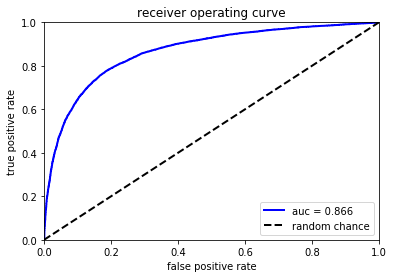

In [9]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels[:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

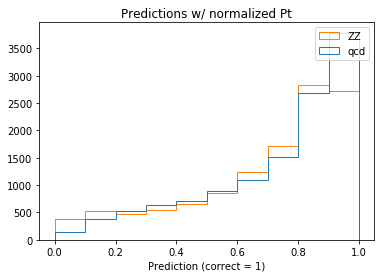

In [14]:
indqcd = np.argwhere(testlabels[:,0] ==1)
ind1  = np.argwhere(testlabels[:,1] == 1) 
# ind2  = np.where(testlabels[:,2] == 1)
# ind3  = np.where(testlabels[:,3] == 1)
hist_, bin_edges_ = np.histogram(predict[indqcd])
plt.hist([predict[indqcd, 0].flatten(),predict[ind1, 1].flatten()], histtype = 'step', label = ['qcd', 'ZZ'])
plt.legend()
plt.title('Predictions w/ normalized Pt')
# plt.yscale('log')
plt.xlabel('Prediction (correct = 1)')
plt.show()